# Error estimation in RepLAB

Before explaining things, we initialize the library

In [1]:
run ../../replab_init

Adding RepLAB to the path
Adding RepLAB package to the path
Loading optim package for Octave...
OpenJDK 64-Bit Server VM warning: Archived non-system classes are disabled because the java.system.class.loader property is specified (value = "org.octave.OctClassLoader"). To use archived non-system classes, this property must be not be set
Adding VPI to the path
Adding MOxUnit to the path
Adding embedded YALMIP to the path
Adding embedded SDPT3 solver to the path
Adding MOcov to the path


Error estimation will play a central role in RepLAB. Currently, tolerances are baked-in in the representation decomposition algorithms, but we will remove those “magic constants” in the next RepLAB releases, to be replaced by proper error estimation.

Currently, we estimate the error when computing generic samples from equivariant spaces, but the subsequent algorithms do not yet use this estimation in their proceeds.

We distinguish equivariant spaces over finite groups and compact groups, as for finite groups, a deterministic method is used, while compact groups use an iterative Monte Carlo integration method.

## For representations over finite groups

Currently, the main use case of RepLAB is to decompose (signed) permutation representations, that is representations whose matrix forms can be represented exactly in floating point arithmetic (such is the case of matrices with coefficients in $\{−1, 0, 1\}$ ).

We did not study in depth the resulting numerical error, but assume (for now) that the error on the coefficients is within `2*eps(coeff)`, where `eps(coeff)` represents the distance to the neighboring floating point number.
A rough estimate of the Frobenius error on a resulting matrix ``X`` with that error model is

`norm(X, 'fro') * sqrt(size(X, 1) * size(X, 2)) * 5e-16`

## For representations over compact groups

We’ll explain our process on the representation $U \otimes U \otimes U$ where $U$ is the unitary group of dimension 3.

In [2]:
replab.equivariant.plotConvergence(true);
rep = replab.U(3).definingRep.tensorPower(3);

To decompose that representation, we need to take generic samples from the commutant algebra. This is achieved by projecting a random matrix on the invariant subspace using an iterative algorithm. $X_0$ is that random initial matrix, and then our iteration is:

$$ X_{i+1} = \frac{1}{2N} \sum_{j=1}^N \rho_{s_j} X_i \rho_{s_j}^\dagger + \rho_{s_j}^\dagger X_i \rho_{s_j} $$

where $\{ s_j \}$ are sampled from the Haar measure of the group. In our implementation, $N = 3$. The iteration eventually converges (proof of convergence, etc..., will be made in future work).

To control convergence, we do the following. We compute

$$ \Delta_i = || X_{i+1} - X_i ||_\text{FRO} $$

where $|| \cdot ||_\text{FRO}$ is the Frobenius norm, and fit the following function

$$ f(i) = \nu + \alpha \exp (-\beta i ) $$

to our estimates. Note that we perform the fitting by minimizing the square distance of $\log_{10} f(i)$ to $\log_{10} \Delta_i$, and that we implement a variant of $f(i)$ with the same expressiveness that performs numerically better. The value $\nu$ represents the nois floor due to floating point approximations. We can compute the crossing point $\xi = \frac{\ln \alpha - \ln \nu}{\beta}$, where the magnitude of the approximation error $\alpha \exp(-\beta i)$ becomes comparable to the noise floor $\nu$.

Our convergence criteria is as follows:

- The fit must be nondegenerate; in particular, there are sufficiently many data points to estimate the noise floor (which cannot be estimated well until the floating point noise effects are observed).

- We check that the 5% confidence interval for the estimation of the noise floor value represents a deviation of less than an order of magnitude (i.e. a factor 10).

- If the two conditions above are satisfied, we compute the crossing point $\xi$. We proceed with the next check if the current iteration $i \ge \xi + 10$.

- The final test for convergence is that the errors $\Delta_{i-10}, \ldots, \Delta_i$ are all within a factor $10$ of the estimated noise floor. We then return $10 \nu$ as an error estimate.

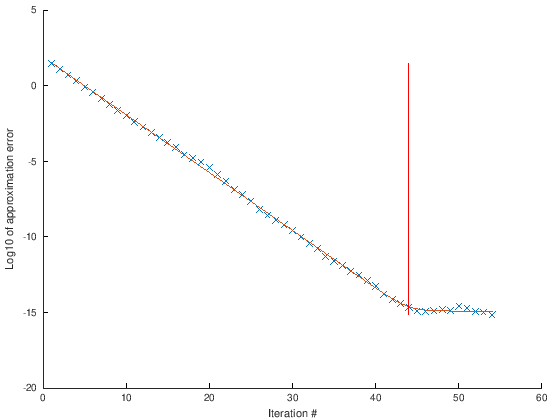

In [3]:
rep.commutant.sample;